In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import Counter
import matplotlib as mpl
import plotly.express as px


In [3]:
# import species and parks data
species = pd.read_csv('species.csv')
del species['Unnamed: 13'] # don't know why this happens, but it does

parks = pd.read_csv('parks.csv')

parks.head()

C:\Users\elija\AppData\Local\Temp\ipykernel_18284\1052522872.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv('species.csv')


,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


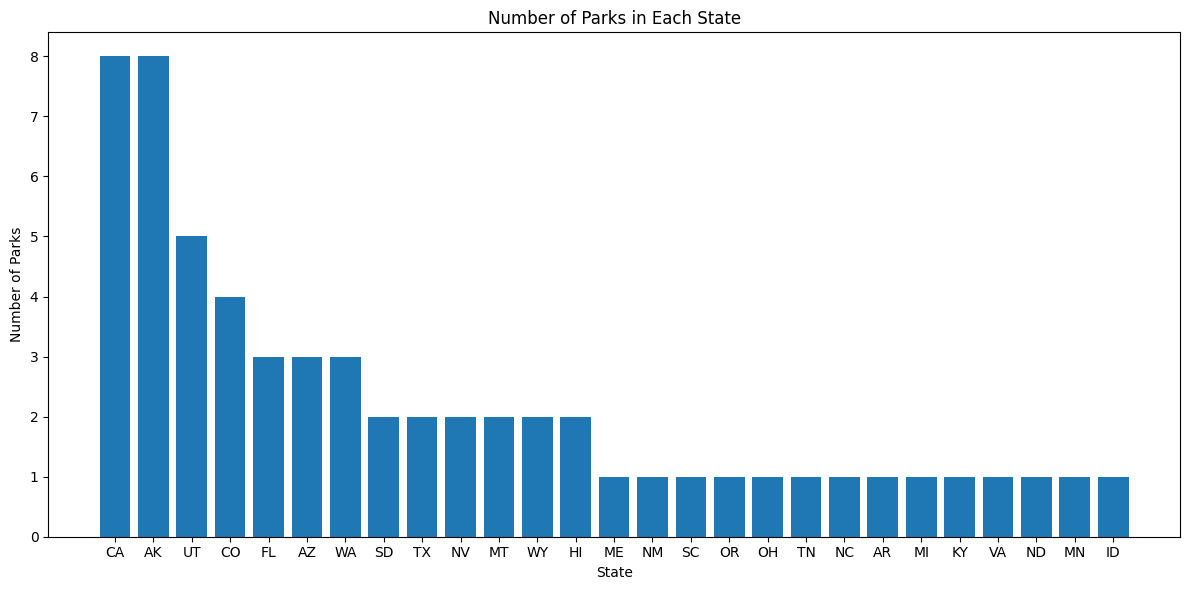

In [4]:
# count the number of parks in each state
state_counts = Counter()

for state in parks['State']:
    for s in state.split(','):
        state_counts[s.strip()] += 1

# plot in order of number of parks
state_counts = dict(state_counts)
state_counts = dict(sorted(state_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(state_counts.keys(), state_counts.values())
plt.xlabel('State')
plt.ylabel('Number of Parks')
plt.title('Number of Parks in Each State')
plt.tight_layout()
plt.show()

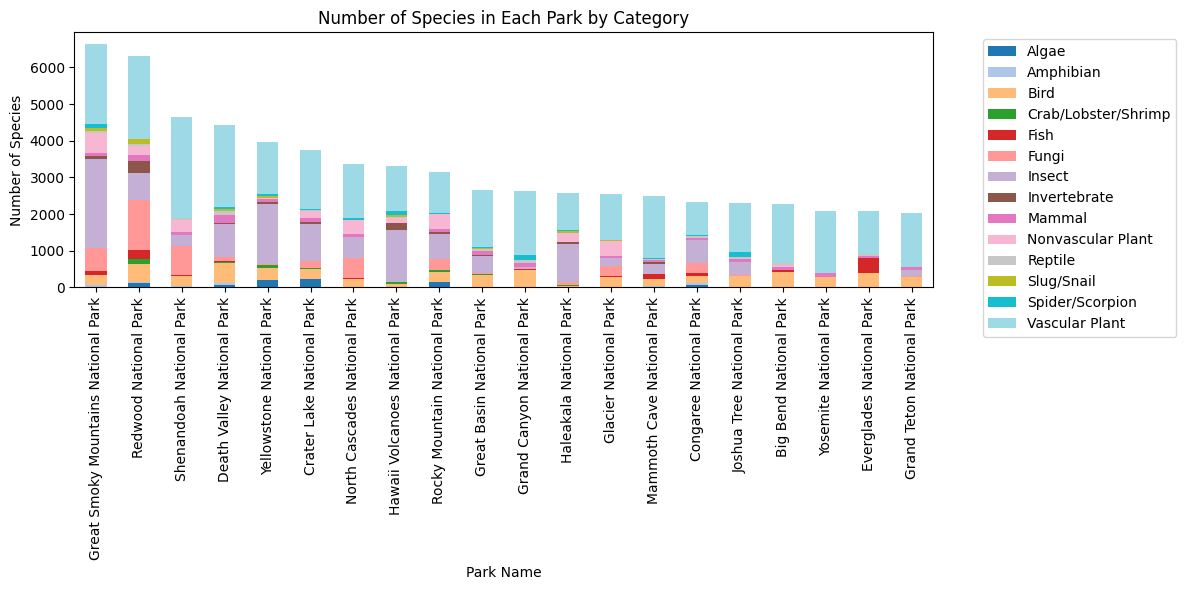

In [5]:
# Compute total species per park and get the top 10 parks, sorted
top_parks = species.groupby('Park Name').size().nlargest(20).index

# Filter dataset for only top parks
species_top = species[species['Park Name'].isin(top_parks)]

# Group by park and category, then reshape for stacked bar plot
species_cat = species_top.groupby(['Park Name', 'Category']).size().unstack().fillna(0)

# Reorder to ensure the x-axis follows the most diverse parks
species_cat = species_cat.loc[top_parks]  

# Plot
colors = mpl.colormaps['tab20'].colors  # 'tab20' provides 20 distinct colors
ax = species_cat.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# Formatting
plt.title('Number of Species in Each Park by Category')
plt.ylabel('Number of Species')
plt.xlabel('Park Name')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()

plt.show()

In [6]:
# Get species total for each park
species_total = species.groupby('Park Name').size()

# Assign a name to the Series
species_total = species_total.rename("Species Count").astype(int)

# Join to parks data
parks = parks.join(species_total, on='Park Name').sort_values('Park Name')

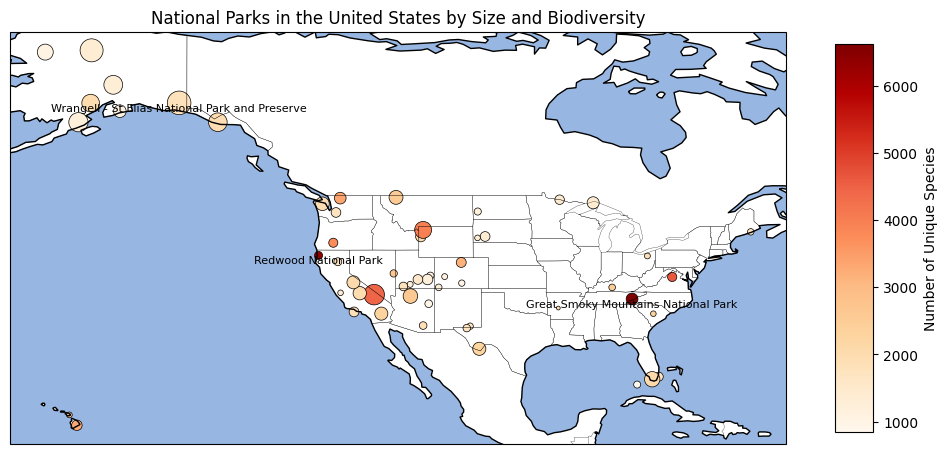

In [7]:
# Create a map
fig = plt.figure(figsize=(10, 10))
plt.rcParams['figure.dpi'] = 700

# Add a map projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add natural features
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=.2)
ax.add_feature(cfeature.STATES, linestyle='-', linewidth=.2)

# Normalize the species count to get a suitable color scale
norm = mpl.colors.Normalize(vmin=parks['Species Count'].min(), vmax=parks['Species Count'].max())

# Create scatter plot for parks with color reflecting 'Species Count'
scatter = ax.scatter(
    parks['Longitude'], parks['Latitude'], 
    c=parks['Species Count'], s=(parks['Acres'])**(1/2) / 10,
    cmap='OrRd', norm=norm, alpha=1, edgecolors='k', linewidth=0.5
)

# Add labels for specific parks
for park in ['Great Smoky Mountains National Park', 
             'Wrangell - St Elias National Park and Preserve', 
             'Redwood National Park']:
    row = parks[parks['Park Name'] == park]
    if not row.empty:
        ax.text(row['Longitude'].iloc[0], row['Latitude'].iloc[0], park, 
                fontsize=8, ha='center', va='top')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.4, aspect=10)
cbar.set_label('Number of Unique Species')

# Add title
plt.title('National Parks in the United States by Size and Biodiversity')

# Layout and show
plt.tight_layout()
plt.show()


In [8]:
species.head(1)

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN


In [9]:
# plotly treemap of species-genus etc by category
species_mammal = pd.read_csv('species_mammals.csv')

# combine common names and scientific names
mammal_info = species_mammal[['Category', 'Order', 'Family', 'Scientific Name', 'Common Names']].drop_duplicates().dropna()

# ensure no two species have the same scientific name
mammal_info = mammal_info.drop_duplicates(subset='Scientific Name')
mammal_info.loc[:, 'Name'] = mammal_info['Common Names'] + ' (' + mammal_info['Scientific Name'] + ')'

In [10]:

fig = px.treemap(mammal_info.drop_duplicates().dropna(),
                    path=['Category', 'Order', 'Family', 'Name'],
                    title='Species by Category, Order, Family, and Name')


In [11]:
fig

In [12]:
import altair as alt

In [13]:
park_name_mapping = {
    'Acadia NP': 'Acadia National Park',
    'Arches NP': 'Arches National Park',
    'Badlands NP': 'Badlands National Park',
    'Big Bend NP': 'Big Bend National Park',
    'Biscayne NP': 'Biscayne National Park',
    'Black Canyon of the Gunnison NP': 'Black Canyon of the Gunnison National Park',
    'Bryce Canyon NP': 'Bryce Canyon National Park',
    'Canyonlands NP': 'Canyonlands National Park',
    'Capitol Reef NP': 'Capitol Reef National Park',
    'Carlsbad Caverns NP': 'Carlsbad Caverns National Park',
    'Channel Islands NP': 'Channel Islands National Park',
    'Congaree NP': 'Congaree National Park',
    'Crater Lake NP': 'Crater Lake National Park',
    'Cuyahoga Valley NP': 'Cuyahoga Valley National Park',
    'Death Valley NP': 'Death Valley National Park',
    'Denali NP & PRES': 'Denali National Park and Preserve',
    'Dry Tortugas NP': 'Dry Tortugas National Park',
    'Everglades NP': 'Everglades National Park',
    'Gates of the Arctic NP & PRES': 'Gates Of The Arctic National Park and Preserve',
    'Gateway Arch NP': 'Gateway Arch National Park',
    'Glacier Bay NP & PRES': 'Glacier Bay National Park and Preserve',
    'Glacier NP': 'Glacier National Park',
    'Grand Canyon NP': 'Grand Canyon National Park',
    'Grand Teton NP': 'Grand Teton National Park',
    'Great Basin NP': 'Great Basin National Park',
    'Great Sand Dunes NP & PRES': 'Great Sand Dunes National Park and Preserve',
    'Great Smoky Mountains NP': 'Great Smoky Mountains National Park',
    'Guadalupe Mountains NP': 'Guadalupe Mountains National Park',
    'Haleakala NP': 'Haleakala National Park',
    'Hawaii Volcanoes NP': 'Hawaii Volcanoes National Park',
    'Hot Springs NP': 'Hot Springs National Park',
    'Indiana Dunes NP': 'Indiana Dunes National Park',
    'Isle Royale NP': 'Isle Royale National Park',
    'Joshua Tree NP': 'Joshua Tree National Park',
    'Katmai NP & PRES': 'Katmai National Park and Preserve',
    'Kenai Fjords NP': 'Kenai Fjords National Park',
    'Kings Canyon NP': 'Sequoia and Kings Canyon National Parks',
    'Kobuk Valley NP': 'Kobuk Valley National Park',
    'Lake Clark NP & PRES': 'Lake Clark National Park and Preserve',
    'Lassen Volcanic NP': 'Lassen Volcanic National Park',
    'Mammoth Cave NP': 'Mammoth Cave National Park',
    'Mesa Verde NP': 'Mesa Verde National Park',
    'Mount Rainier NP': 'Mount Rainier National Park',
    'National Park of American Samoa': 'National Park of American Samoa',
    'New River Gorge NP & PRES': 'New River Gorge National Park and Preserve',
    'North Cascades NP': 'North Cascades National Park',
    'Olympic NP': 'Olympic National Park',
    'Petrified Forest NP': 'Petrified Forest National Park',
    'Pinnacles NP': 'Pinnacles National Park',
    'Redwood NP': 'Redwood National Park',
    'Rocky Mountain NP': 'Rocky Mountain National Park',
    'Saguaro NP': 'Saguaro National Park',
    'Sequoia NP': 'Sequoia and Kings Canyon National Parks',
    'Shenandoah NP': 'Shenandoah National Park',
    'Theodore Roosevelt NP': 'Theodore Roosevelt National Park',
    'Virgin Islands NP': 'Virgin Islands National Park',
    'Voyageurs NP': 'Voyageurs National Park',
    'White Sands NP': 'White Sands National Park',
    'Wind Cave NP': 'Wind Cave National Park',
    'Wrangell-St. Elias NP & PRES': 'Wrangell - St Elias National Park and Preserve',
    'Yellowstone NP': 'Yellowstone National Park',
    'Yosemite NP': 'Yosemite National Park',
    'Zion NP': 'Zion National Park'
}

In [14]:
visits = pd.read_csv('visits.csv')


#  Kings Canyon and Sequoia
kings_mask = visits['ParkName'] == 'Kings Canyon NP'
sequoia_mask = visits['ParkName'] == 'Sequoia NP'

# Combine the data for  parks
combined_data = visits[kings_mask | sequoia_mask].copy()

# Group by year and sum the visits
combined_grouped = combined_data.groupby('Year').agg({
    'Region': 'first', 
    'State': 'first', 
    'RecreationVisits': 'sum'
}).reset_index()

# Add the new park name
combined_grouped['ParkName'] = 'Sequoia and Kings Canyon National Parks'

# Remove the original Kings Canyon and Sequoia rows
df_cleaned = visits[~(kings_mask | sequoia_mask)].copy()

# Concatenate with the new combined rows
df_final = pd.concat([df_cleaned, combined_grouped], ignore_index=True)

# Sort by ParkName and Year to make the dataframe organized
visits = df_final.sort_values(['ParkName', 'Year']).reset_index(drop=True)

visits['ParkName'] = visits['ParkName'].map(park_name_mapping)
visits

,ParkName,Region,State,Year,RecreationVisits
0,Acadia National Park,Northeast,ME,1979,2787366
1,Acadia National Park,Northeast,ME,1980,2779666
2,Acadia National Park,Northeast,ME,1981,2997972
3,Acadia National Park,Northeast,ME,1982,3572114
4,Acadia National Park,Northeast,ME,1983,4124639
...,...,...,...,...,...
2795,Zion National Park,Intermountain,UT,2020,3591254
2796,Zion National Park,Intermountain,UT,2021,5039835
2797,Zion National Park,Intermountain,UT,2022,4692417
2798,Zion National Park,Intermountain,UT,2023,4623238


In [15]:
conservation = species.groupby('Park Name').value_counts(['Conservation Status'])
pd.DataFrame(conservation)

count
Park Name            Conservation Status       
Acadia National Park Species of Concern      65
                     Under Review             4
                     Endangered               3
                     In Recovery              2
                     Threatened               1
...                                         ...
Zion National Park   Species of Concern      89
                     Endangered               5
                     Threatened               3
                     In Recovery              1
                     Under Review             1

[271 rows x 1 columns]

In [16]:
visits.columns = ['Park Name', 'Region', 'State', 'Year', 'RecreationVisits']

visits

,Park Name,Region,State,Year,RecreationVisits
0,Acadia National Park,Northeast,ME,1979,2787366
1,Acadia National Park,Northeast,ME,1980,2779666
2,Acadia National Park,Northeast,ME,1981,2997972
3,Acadia National Park,Northeast,ME,1982,3572114
4,Acadia National Park,Northeast,ME,1983,4124639
...,...,...,...,...,...
2795,Zion National Park,Intermountain,UT,2020,3591254
2796,Zion National Park,Intermountain,UT,2021,5039835
2797,Zion National Park,Intermountain,UT,2022,4692417
2798,Zion National Park,Intermountain,UT,2023,4623238


In [17]:
filtered_visits = visits[(visits['Year'] == 2022) & (visits['Park Name'].notna())]
px.treemap(filtered_visits, 
           path=['Region', 'State', 'Park Name'],
           values='RecreationVisits',
           title='National Park Visits in 2022')

In [18]:
species

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119243,ZION-2791,Zion National Park,Vascular Plant,Solanales,Solanaceae,Solanum triflorum,Cut-Leaf Nightshade,Approved,Present,Native,Uncommon,NaN,NaN
119244,ZION-2792,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis arizonica,Canyon Grape,Approved,Present,Native,Uncommon,NaN,NaN
119245,ZION-2793,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis vinifera,Wine Grape,Approved,Present,Not Native,Uncommon,NaN,NaN
119246,ZION-2794,Zion National Park,Vascular Plant,Zygophyllales,Zygophyllaceae,Larrea tridentata,Creosote Bush,Approved,Present,Native,Rare,NaN,NaN


In [19]:
species_counts = pd.DataFrame(species.groupby('Park Name').value_counts(['Category'])).reset_index()
species_counts

,Park Name,Category,count
0,Acadia National Park,Vascular Plant,1226
1,Acadia National Park,Bird,364
2,Acadia National Park,Mammal,55
3,Acadia National Park,Fish,38
4,Acadia National Park,Amphibian,15
...,...,...,...
544,Zion National Park,Bird,301
545,Zion National Park,Mammal,80
546,Zion National Park,Reptile,30
547,Zion National Park,Fish,15


In [20]:
conservation = pd.DataFrame(species.groupby('Park Name').value_counts(['Conservation Status'])).reset_index()
c_order = ['In Recovery', 'Species of Concern', 'Threatened', 'Endangered', 'Extinct']
conservation

,Park Name,Conservation Status,count
0,Acadia National Park,Species of Concern,65
1,Acadia National Park,Under Review,4
2,Acadia National Park,Endangered,3
3,Acadia National Park,In Recovery,2
4,Acadia National Park,Threatened,1
...,...,...,...
266,Zion National Park,Species of Concern,89
267,Zion National Park,Endangered,5
268,Zion National Park,Threatened,3
269,Zion National Park,In Recovery,1


In [21]:
custom_palette = [
    '#1f77b4',  # Muted blue
    '#ff7f0e',  # Safety orange
    '#2ca02c',  # Cooked asparagus green
    '#d62728',  # Brick red
    '#9467bd',  # Muted purple
    '#8c564b',  # Chestnut brown
    '#e377c2',  # Raspberry yogurt pink
    '#7f7f7f',  # Middle gray
    '#bcbd22',  # Curry yellow-green
    '#17becf'   # Blue-teal
]

hex_colors = [
    "#6929c4",  # 01. Purple 70
    "#1192e8",  # 02. Cyan 50
    "#005d5d",  # 03. Teal 70
    "#9f1853",  # 04. Magenta 70
    "#fa4d56",  # 05. Red 50
    "#570408",  # 06. Red 90
    "#198038",  # 07. Green 60
    "#002d9c",  # 08. Blue 80
    "#ee538b",  # 09. Magenta 50
    "#b28600",  # 10. Yellow 50
    "#009d9a",  # 11. Teal 50
    "#012749",  # 12. Cyan 90
    "#8a3800",  # 13. Orange 70
    "#a56eff"   # 14. Purple 50
]

In [29]:
# Create a selection object
selection = alt.selection_point(fields=['Park Name'], empty=True)

# 1. Create the map visualization
states = alt.topo_feature('https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/us-10m.json', 'states')
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('albersUsa')

map_chart = alt.Chart(parks).mark_circle().add_params(
    selection
).encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.Size('Acres:Q', scale=alt.Scale(range=[50, 500])),
    color=alt.condition(selection, alt.Color('Species Count:Q', scale=alt.Scale(scheme='reds')), 
                        alt.value('gray')),
    tooltip=['Park Name:N', 'State:N', 'Acres:Q', 'Species Count:Q']
)

min_year = visits['Year'].min()
max_year = visits['Year'].max()
step = 2  

# 2. Create the line chart of visits
line_chart = alt.Chart(visits).mark_line(strokeWidth=1).encode(
    x=alt.X('Year:T'),
    y='RecreationVisits:Q',
    color=alt.condition(selection, alt.Color('Park Name:N', scale=alt.Scale(range=custom_palette)), 
                        alt.value('#e0e0e0')),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.3)),
    tooltip=['Park Name:N', 'Year:T', 'RecreationVisits:Q']
).properties(
    width=600,
    height=400,
    title='Park Visitation Over Time'
).transform_filter(
    selection
)

species_chart = alt.Chart(species_counts).mark_bar().add_params(
    selection
).encode(
    x=alt.X('Category:N').sort('-y'),
    y='count:Q',
    color='Park Name:N',
    tooltip=['Park Name:N', 'Category:N', 'count:Q'],
    order=alt.Order('sum:Q', sort='descending')
).properties(
    width=600,
    height=300,
    title='Species Count by Category',
).transform_filter(
    selection
)

(background + map_chart).properties(
    width=800,
    height=500,
    title='National Parks in the United States'
) & (line_chart & species_chart)

alt.VConcatChart(...)